In [1]:
import glob
import logging
import os
import pickle
import random
import re
import sys
import time

import numpy as np
import torch
from hydra.core.hydra_config import HydraConfig
from omegaconf import OmegaConf
from rfdiffusion.inference import utils as iu
from rfdiffusion.util import writepdb, writepdb_multi


def make_deterministic(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


# @hydra.main(version_base=None, config_path="../config/inference", config_name="base")
def run_inference(conf: HydraConfig) -> None:
    log = logging.getLogger(__name__)
    # Remove all handlers associated with the logger
    for handler in log.handlers[:]:
        log.removeHandler(handler)
    # Set the logging level
    log.setLevel(logging.INFO)
    # Create a stream handler that outputs to sys.stdout (or sys.stderr)
    handler = logging.StreamHandler(sys.stdout)  # or sys.stderr
    # Set a format for the handler
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    # Add the handler to the logger
    log.addHandler(handler)

    if conf.inference.deterministic:
        make_deterministic()

    # Check for available GPU and print result of check
    if torch.cuda.is_available():
        device_name = torch.cuda.get_device_name(torch.cuda.current_device())
        log.info(f"Found GPU with device_name {device_name}. Will run RFdiffusion on {device_name}")
    else:
        log.info("////////////////////////////////////////////////")
        log.info("///// NO GPU DETECTED! Falling back to CPU /////")
        log.info("////////////////////////////////////////////////")

    # Initialize sampler and target/contig.
    sampler = iu.sampler_selector(conf, logger=log)

    # Loop over number of designs to sample.
    design_startnum = sampler.inf_conf.design_startnum
    if sampler.inf_conf.design_startnum == -1:
        existing = glob.glob(sampler.inf_conf.output_prefix + "*.pdb")
        indices = [-1]
        for e in existing:
            print(e)
            m = re.match(".*_(\d+)\.pdb$", e)
            print(m)
            if not m:
                continue
            m = m.groups()[0]
            indices.append(int(m))
        design_startnum = max(indices) + 1

    denoised_xyz_stack = None
    px0_xyz_stack = None
    for i_des in range(design_startnum, design_startnum + sampler.inf_conf.num_designs):
        if conf.inference.deterministic:
            make_deterministic(i_des)

        start_time = time.time()
        extra_string = ""
        for p in sampler.potential_conf.guiding_potentials:
            if 'olig_contacts' in p:
                pattern = r"type:olig_contacts,weight_intra:(\d+(\.\d+)?),weight_inter:(\d+(\.\d+)?)"
                match = re.search(pattern, p)
                weight_intra, weight_inter = match.group(1), match.group(3)
                scale = sampler.potential_conf.guide_scale
                extra_string = f"_olig_contacts_{weight_intra}_{weight_inter}_{scale}"
        out_prefix = f"{sampler.inf_conf.output_prefix}_{i_des}{extra_string}"
        log.info(f"Making design {out_prefix}")
        if sampler.inf_conf.cautious and os.path.exists(out_prefix + ".pdb"):
            log.info(
                f"(cautious mode) Skipping this design because {out_prefix}.pdb already exists."
            )
            continue

        x_init, seq_init = sampler.sample_init()
        denoised_xyz_stack = []
        px0_xyz_stack = []
        seq_stack = []
        plddt_stack = []

        x_t = torch.clone(x_init)
        seq_t = torch.clone(seq_init)

        # Loop over number of reverse diffusion time steps.
        for t in range(int(sampler.t_step_input), sampler.inf_conf.final_step - 1, -1):
            px0, x_t, seq_t, plddt = sampler.sample_step(
                t=t, x_t=x_t, seq_init=seq_t, final_step=sampler.inf_conf.final_step
            )
            px0_xyz_stack.append(px0)
            denoised_xyz_stack.append(x_t)
            seq_stack.append(seq_t)
            plddt_stack.append(plddt[0])  # remove singleton leading dimension

        # Flip order for better visualization in pymol
        denoised_xyz_stack = torch.stack(denoised_xyz_stack)
        denoised_xyz_stack = torch.flip(
            denoised_xyz_stack,
            [
                0,
            ],
        )
        px0_xyz_stack = torch.stack(px0_xyz_stack)
        px0_xyz_stack = torch.flip(
            px0_xyz_stack,
            [
                0,
            ],
        )

        # For logging -- don't flip
        plddt_stack = torch.stack(plddt_stack)

        # Save outputs
        os.makedirs(os.path.dirname(out_prefix), exist_ok=True)
        final_seq = seq_stack[-1]

        # Output glycines, except for motif region
        final_seq = torch.where(
            torch.argmax(seq_init, dim=-1) == 21, 7, torch.argmax(seq_init, dim=-1)
        )  # 7 is glycine

        bfacts = torch.ones_like(final_seq.squeeze())
        # make bfact=0 for diffused coordinates
        bfacts[torch.where(torch.argmax(seq_init, dim=-1) == 21, True, False)] = 0
        # pX0 last step
        out = f"{out_prefix}.pdb"

        # Now don't output sidechains
        writepdb(
            out,
            denoised_xyz_stack[0, :, :4],
            final_seq,
            sampler.binderlen,
            chain_idx=sampler.chain_idx,
            bfacts=bfacts,
        )

        # run metadata
        trb = dict(
            config=OmegaConf.to_container(sampler._conf, resolve=True),
            plddt=plddt_stack.cpu().numpy(),
            device=torch.cuda.get_device_name(torch.cuda.current_device())
            if torch.cuda.is_available()
            else "CPU",
            time=time.time() - start_time,
        )
        if hasattr(sampler, "contig_map"):
            for key, value in sampler.contig_map.get_mappings().items():
                trb[key] = value
        with open(f"{out_prefix}.trb", "wb") as f_out:
            pickle.dump(trb, f_out)

        if sampler.inf_conf.write_trajectory:
            # trajectory pdbs
            traj_prefix = (
                os.path.dirname(out_prefix) + "/traj/" + os.path.basename(out_prefix)
            )
            os.makedirs(os.path.dirname(traj_prefix), exist_ok=True)

            out = f"{traj_prefix}_Xt-1_traj.pdb"
            writepdb_multi(
                out,
                denoised_xyz_stack,
                bfacts,
                final_seq.squeeze(),
                use_hydrogens=False,
                backbone_only=False,
                chain_ids=sampler.chain_idx,
            )

            out = f"{traj_prefix}_pX0_traj.pdb"
            writepdb_multi(
                out,
                px0_xyz_stack,
                bfacts,
                final_seq.squeeze(),
                use_hydrogens=False,
                backbone_only=False,
                chain_ids=sampler.chain_idx,
            )

        log.info(f"Finished design in {(time.time()-start_time)/60:.2f} minutes")
    
    return denoised_xyz_stack, px0_xyz_stack

In [2]:
from pathlib import Path
from hydra.core.config_store import ConfigStore
from hydra import compose, initialize

def run_hydra(symmetry="C8", weight_intra=1, weight_inter=0.1, L=480, guide_scale=2.0, num=-1):
    config_dir = "./modules/RFdiffusion/config/inference"  # Adjust path as necessary
    assert Path(config_dir).exists()
    config_name = "symmetry"
    with initialize(config_path=config_dir):
        # Manually specify overrides
        order = symmetry[1:]
          
        assert order.isdigit()
        assert L % int(order) == 0
        overrides = [
            # "config-name=symmetry",
            "inference.cautious=True",
            f"inference.design_startnum={num}",
            "inference.write_trajectory=False",
            "inference.deterministic=True",
            f"inference.symmetry={symmetry}",
            "inference.num_designs=1",
            f"inference.output_prefix=example_outputs/{symmetry}_notebook/{symmetry}_oligo",
            f'potentials.guiding_potentials=["type:olig_contacts,weight_intra:{weight_intra},weight_inter:{weight_inter}"]',
            "potentials.olig_intra_all=True",
            "potentials.olig_inter_all=True",
            f"potentials.guide_scale={guide_scale}",
            "potentials.guide_decay=quadratic",
            f'contigmap.contigs=["{L}-{L}"]'
        ]
        cfg = compose(config_name=config_name, overrides=overrides)
        denoised_xyz_stack, px0_xyz_stack = run_inference(cfg)  # Call the modified main function with the config
        return denoised_xyz_stack, px0_xyz_stack

In [3]:
denoised_xyz_stack, px0_xyz_stack = run_hydra(L=480, guide_scale=2.0, num=23, weight_intra=1, weight_inter=0.2)

/tmp/ipykernel_650719/2943448182.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path=config_dir):


2024-04-29 02:53:53,630 - __main__ - INFO - Found GPU with device_name NVIDIA GeForce GTX 1080 Ti. Will run RFdiffusion on NVIDIA GeForce GTX 1080 Ti


/nfs/staff-hdd/hetzell/miniconda3/envs/protein-design-env/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'symmetry': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Reading models from /nfs/staff-ssd/hetzell/code/protein_design/modules/RFdiffusion/rfdiffusion/inference/../../models
This is inf_conf.ckpt_path
/nfs/staff-ssd/hetzell/code/protein_design/modules/RFdiffusion/rfdiffusion/inference/../../models/Base_ckpt.pt
Assembling -model, -diffuser and -preprocess configs from checkpoint
USING MODEL CONFIG: self._conf[model][n_extra_block] = 4
USING MODEL CONFIG: self._conf[model][n_main_block] = 32
USING MODEL CONFIG: self._conf[model][n_ref_block] = 4
USING MODEL CONFIG: self._conf[model][d_msa] = 256
USING MODEL CONFIG: self._conf[model][d_msa_full] = 64
USING MODEL CONFIG: self._conf[model][d_pair] = 128
USING MODEL CONFIG: self._conf[model][d_templ] = 64
USING MODEL CONFIG: self._conf[model][n_head_msa] = 8
USING MODEL CONFIG: self._conf[model][n_head_pair] = 4
USING MODEL CONFIG: self._conf[model][n_head_templ] = 4
USING MODEL CONFIG: self._conf[model][d_hidden] = 32
USING MODEL CONFIG: self._conf[model][d_hidden_templ] = 32
USING MODEL CONFIG:


KeyboardInterrupt



In [22]:
ca_coords = denoised_xyz_stack.detach().cpu().numpy()
ca_coords_X0 = px0_xyz_stack.detach().cpu().numpy()

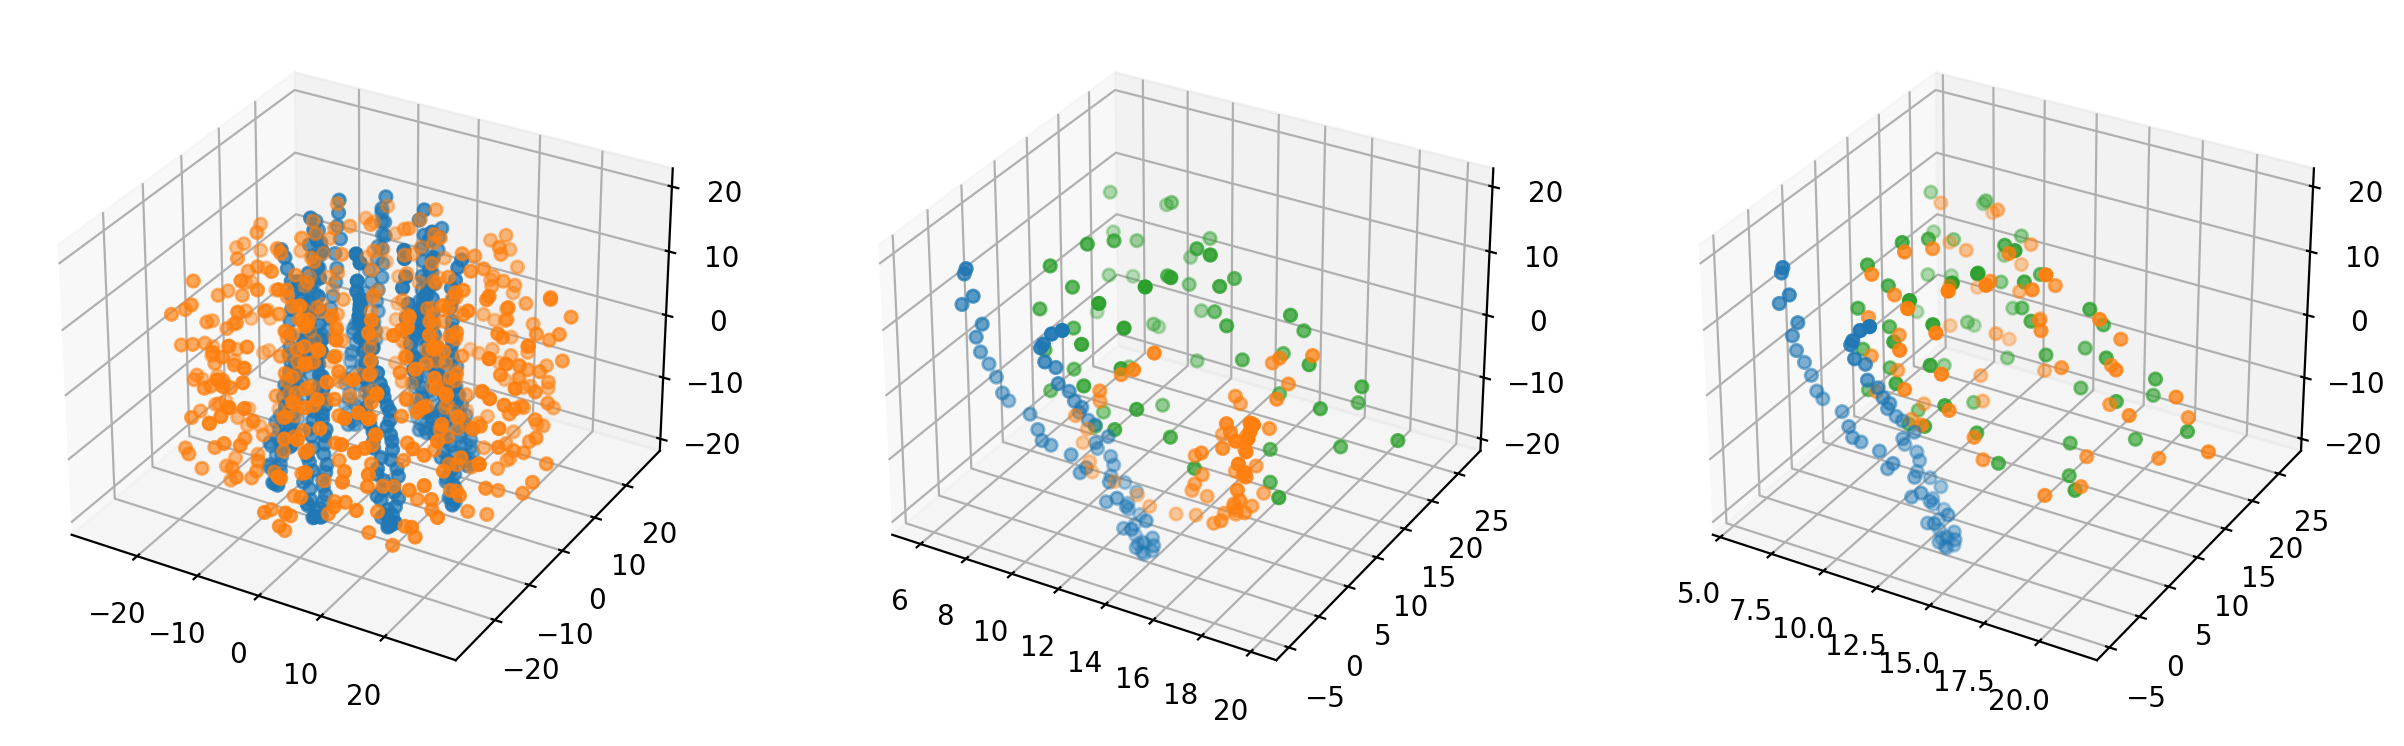

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(15, 5))

# Add 3D subplots
ax1 = fig.add_subplot(131, projection="3d")
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133, projection="3d")

traj = np.array(ca_coords_X0)

# Plotting for the first subplot
idx = -1
ax1.scatter(traj[idx, :, 1, 0], traj[idx, :, 1, 1], traj[idx, :, 1, 2])
idx = 0
ax1.scatter(traj[idx, :, 1, 0], traj[idx, :, 1, 1], traj[idx, :, 1, 2])

# Plotting for the second subplot
idx = -1
ax2.scatter(traj[idx, :60, 1, 0], traj[idx, :60, 1, 1], traj[idx, :60, 1, 2])
idx = 35
ax2.scatter(traj[idx, :60, 1, 0], traj[idx, :60, 1, 1], traj[idx, :60, 1, 2])
idx = 0
ax2.scatter(traj[idx, :60, 1, 0], traj[idx, :60, 1, 1], traj[idx, :60, 1, 2])

# Plotting for the third subplot
idx = -1
ax3.scatter(traj[idx, :60, 1, 0], traj[idx, :60, 1, 1], traj[idx, :60, 1, 2])
idx = 10
ax3.scatter(traj[idx, :60, 1, 0], traj[idx, :60, 1, 1], traj[idx, :60, 1, 2])
idx = 0
ax3.scatter(traj[idx, :60, 1, 0], traj[idx, :60, 1, 1], traj[idx, :60, 1, 2])

plt.show()

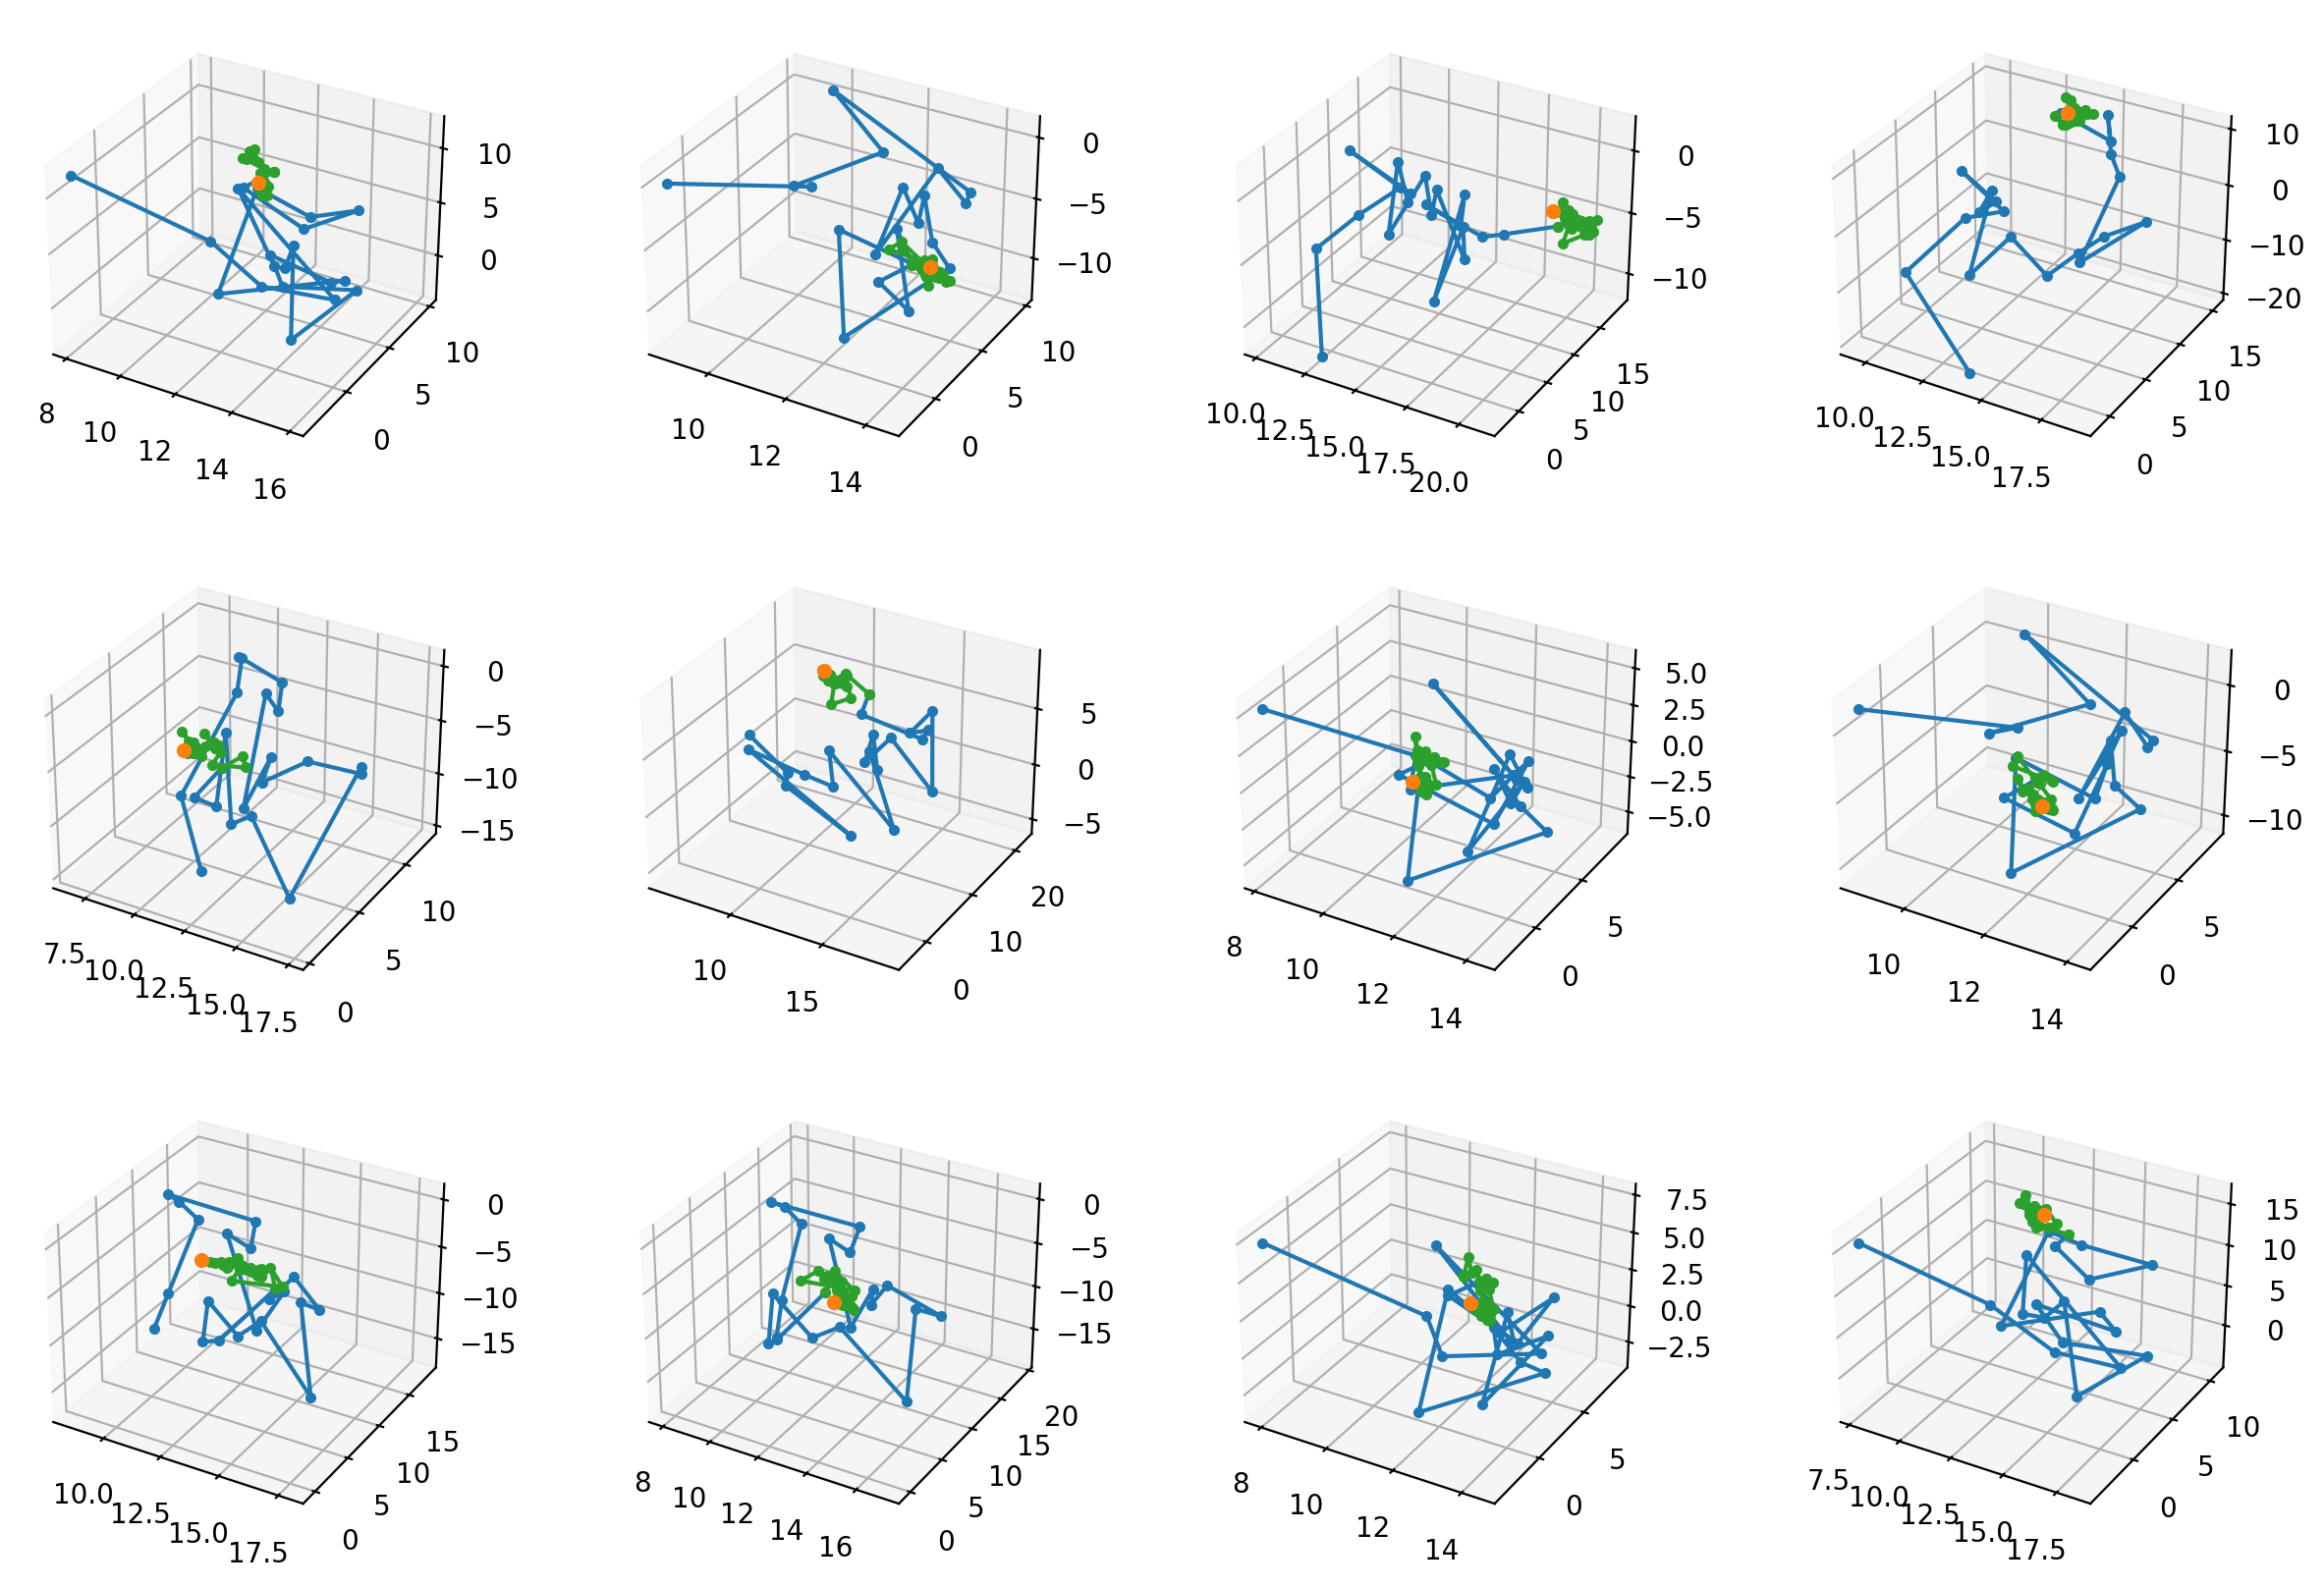

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(15, 10))

atoms = [4, 10, 20, 30, 40, 55, 7, 9, 44, 43, 6, 2]

# Add 3D subplots
ax = []
for i in range(len(atoms)):
    ax.append(fig.add_subplot(3,4,i+1, projection='3d'))

traj = np.array(ca_coords_X0)

start_t = 30
for i, atom_i in enumerate(atoms): 
    axis = ax[i]
    axis.plot(traj[start_t-1:,atom_i,1,0], traj[start_t-1:,atom_i,1,1], traj[start_t-1:,atom_i,1,2], marker='.',color='C0')
    axis.plot(traj[:start_t,atom_i,1,0], traj[:start_t,atom_i,1,1], traj[:start_t,atom_i,1,2], marker='.',color='C2')
    axis.scatter(traj[0,atom_i,1,0], traj[0,atom_i,1,1], traj[0,atom_i,1,2], marker='o', color='C1')


plt.show()

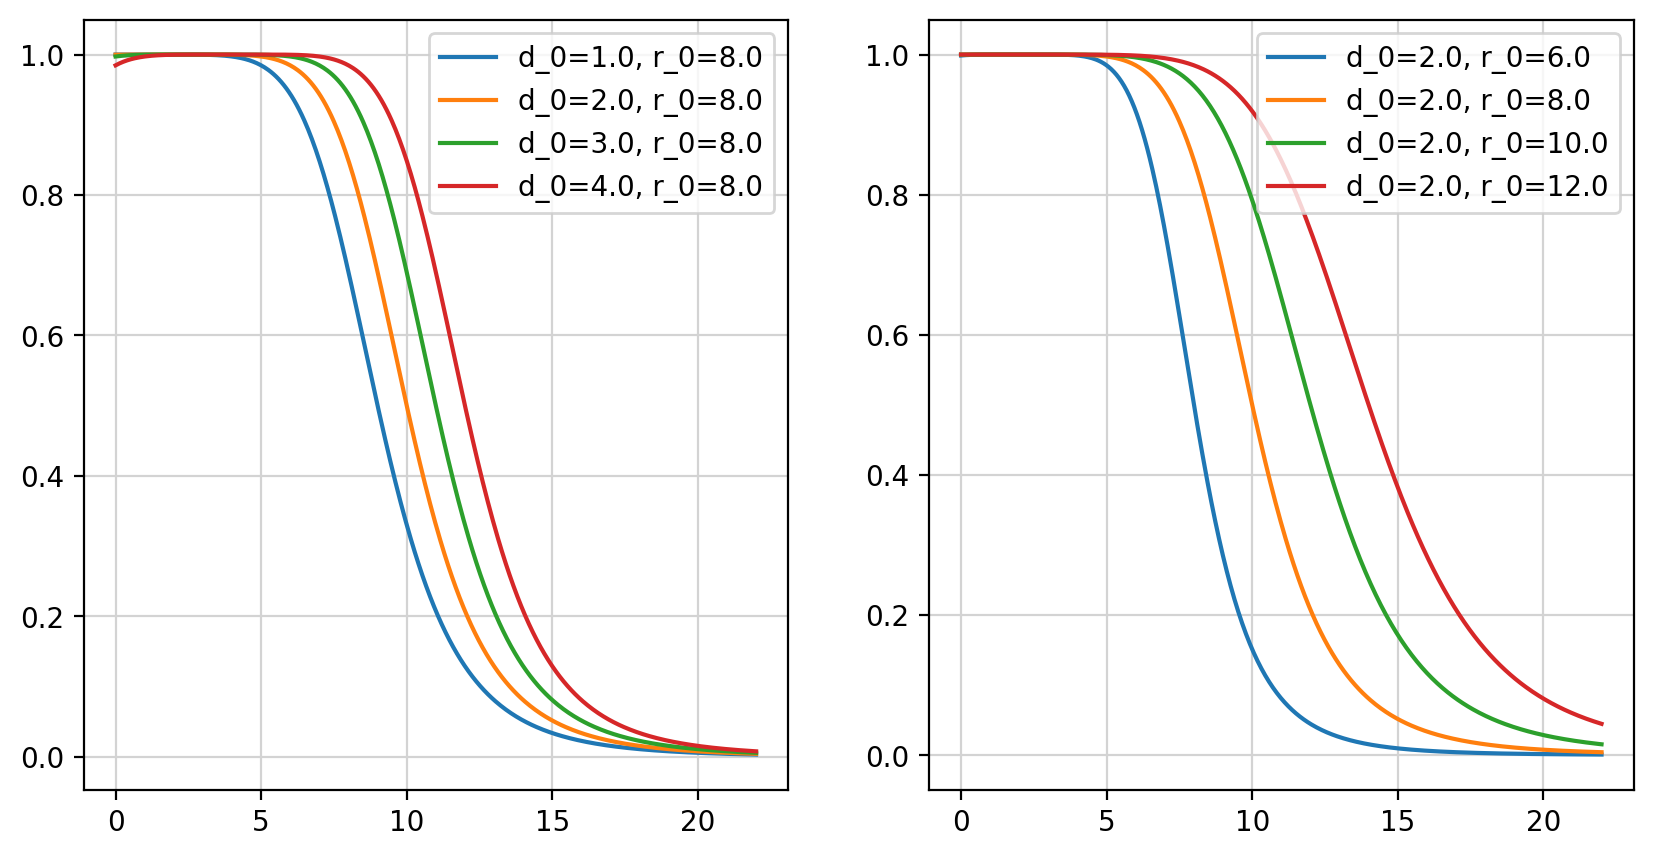

In [3]:
import matplotlib.pyplot as plt


# Investiagte potential

dgram = np.linspace(1e-3,22,500)

def get_potential(dgram, d_0= 2.0, r_0= 8.0):
    divide_by_r_0   = (dgram - d_0) / r_0
    numerator       = np.power(divide_by_r_0,6)
    denominator     = np.power(divide_by_r_0,12)
    potential       = (1 - numerator) / (1 - denominator)
    return potential
    
# plot the potential
fig, ax = plt.subplots(1,2, figsize=(10,5))

axis = ax[0]
axis.plot(dgram, get_potential(dgram, d_0=1.0, r_0=8.0), label="d_0=1.0, r_0=8.0")
axis.plot(dgram, get_potential(dgram, d_0=2.0, r_0=8.0), label="d_0=2.0, r_0=8.0")
axis.plot(dgram, get_potential(dgram, d_0=3.0, r_0=8.0), label="d_0=3.0, r_0=8.0")
axis.plot(dgram, get_potential(dgram, d_0=4.0, r_0=8.0), label="d_0=4.0, r_0=8.0")
axis.grid(':', c="lightgrey")
axis.legend()

axis = ax[1]
axis.plot(dgram, get_potential(dgram, d_0=2.0, r_0=6.0), label="d_0=2.0, r_0=6.0")
axis.plot(dgram, get_potential(dgram, d_0=2.0, r_0=8.0), label="d_0=2.0, r_0=8.0")
axis.plot(dgram, get_potential(dgram, d_0=2.0, r_0=10.0), label="d_0=2.0, r_0=10.0")
axis.plot(dgram, get_potential(dgram, d_0=2.0, r_0=12.0), label="d_0=2.0, r_0=12.0")
axis.grid(':', c="lightgrey")
axis.legend()

In [4]:
def get_chain_distance(step=48, i=0, j=0, num=0):
    # load npy file from ./np_dgrams 
    np_dgram = np.load(f"./np_dgrams_{num}/dgrams_{step}.npy", allow_pickle=True)
    # convert to dict
    np_dgram = np_dgram.item()
    distances = np.array([v for k,v in np_dgram.items() if ((k[0]==i) and (k[1]==j))]).flatten()
    return distances
# distances = np.array([v for k,v in np_dgram.items() if k[0]==0]).flatten()
# distances = np.array([v for k,v in np_dgram.items()]).flatten()

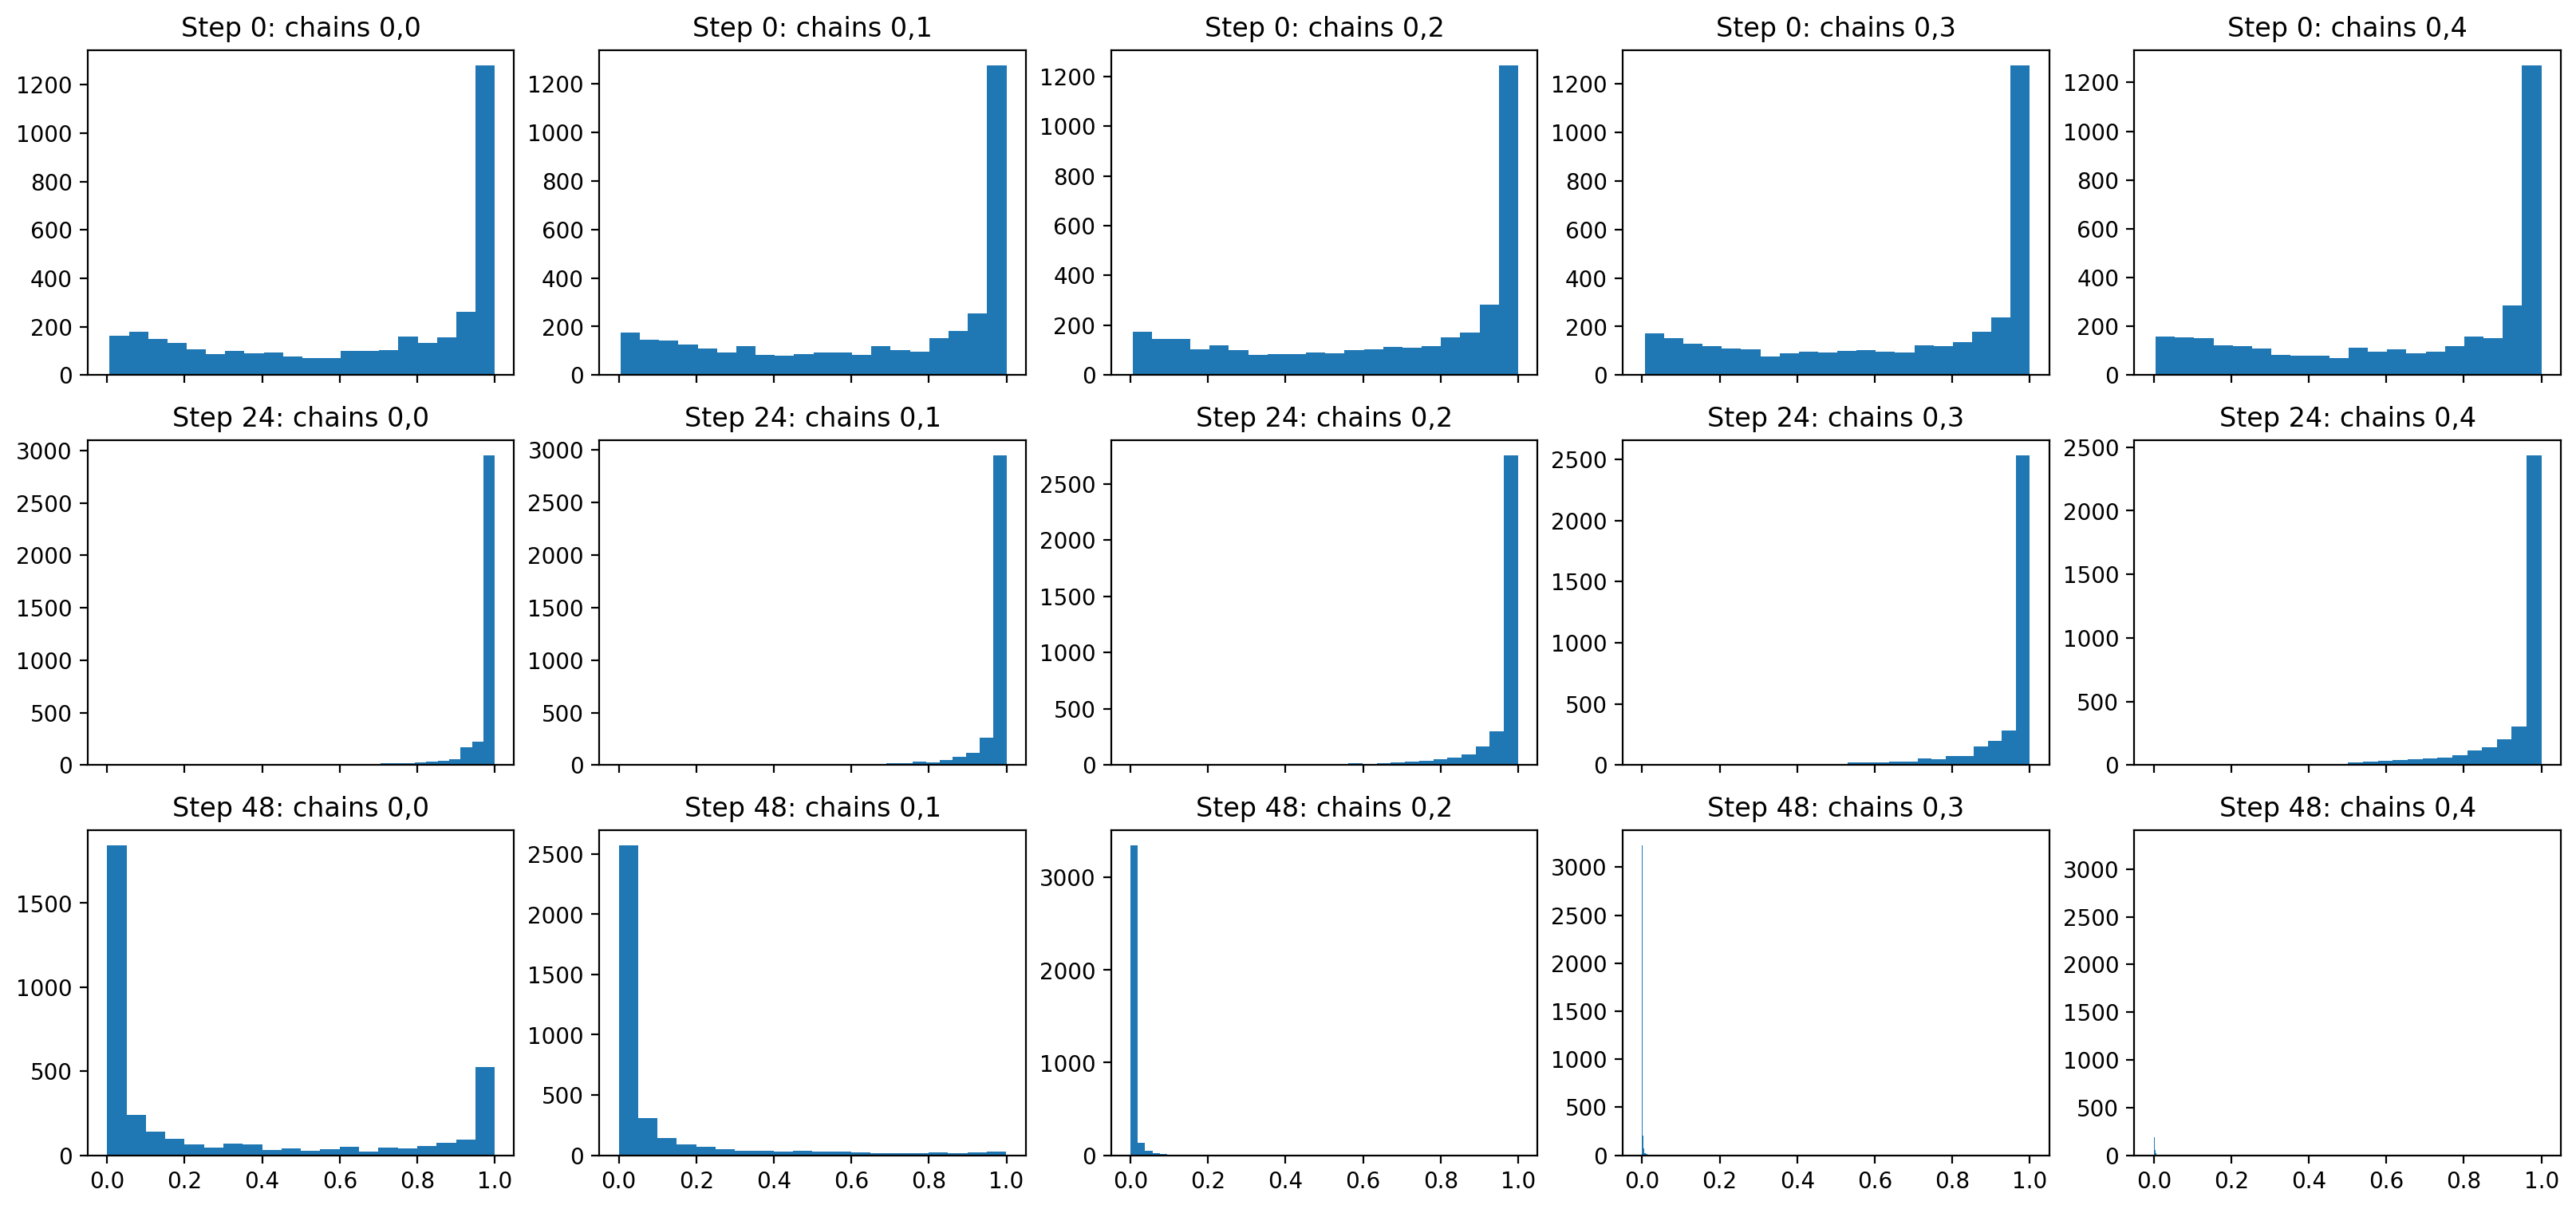

In [14]:
step_T = [0, 24, 48]

rows, cols = len(step_T), 5

fig, ax = plt.subplots(rows,cols,figsize=(4*cols, 3*rows), sharey=False, sharex=True)


for idx in range(rows*cols): 
    j = idx % cols
    i = idx // cols
    T = step_T[i]

    distances = get_chain_distance(T, 0, j)
    distances = get_potential(distances, d_0=2.0, r_0=8.0)
    axis = ax[i,j]
    axis.hist(distances, bins=20)
    axis.set_title(f"Step {T}: chains {0},{j}")


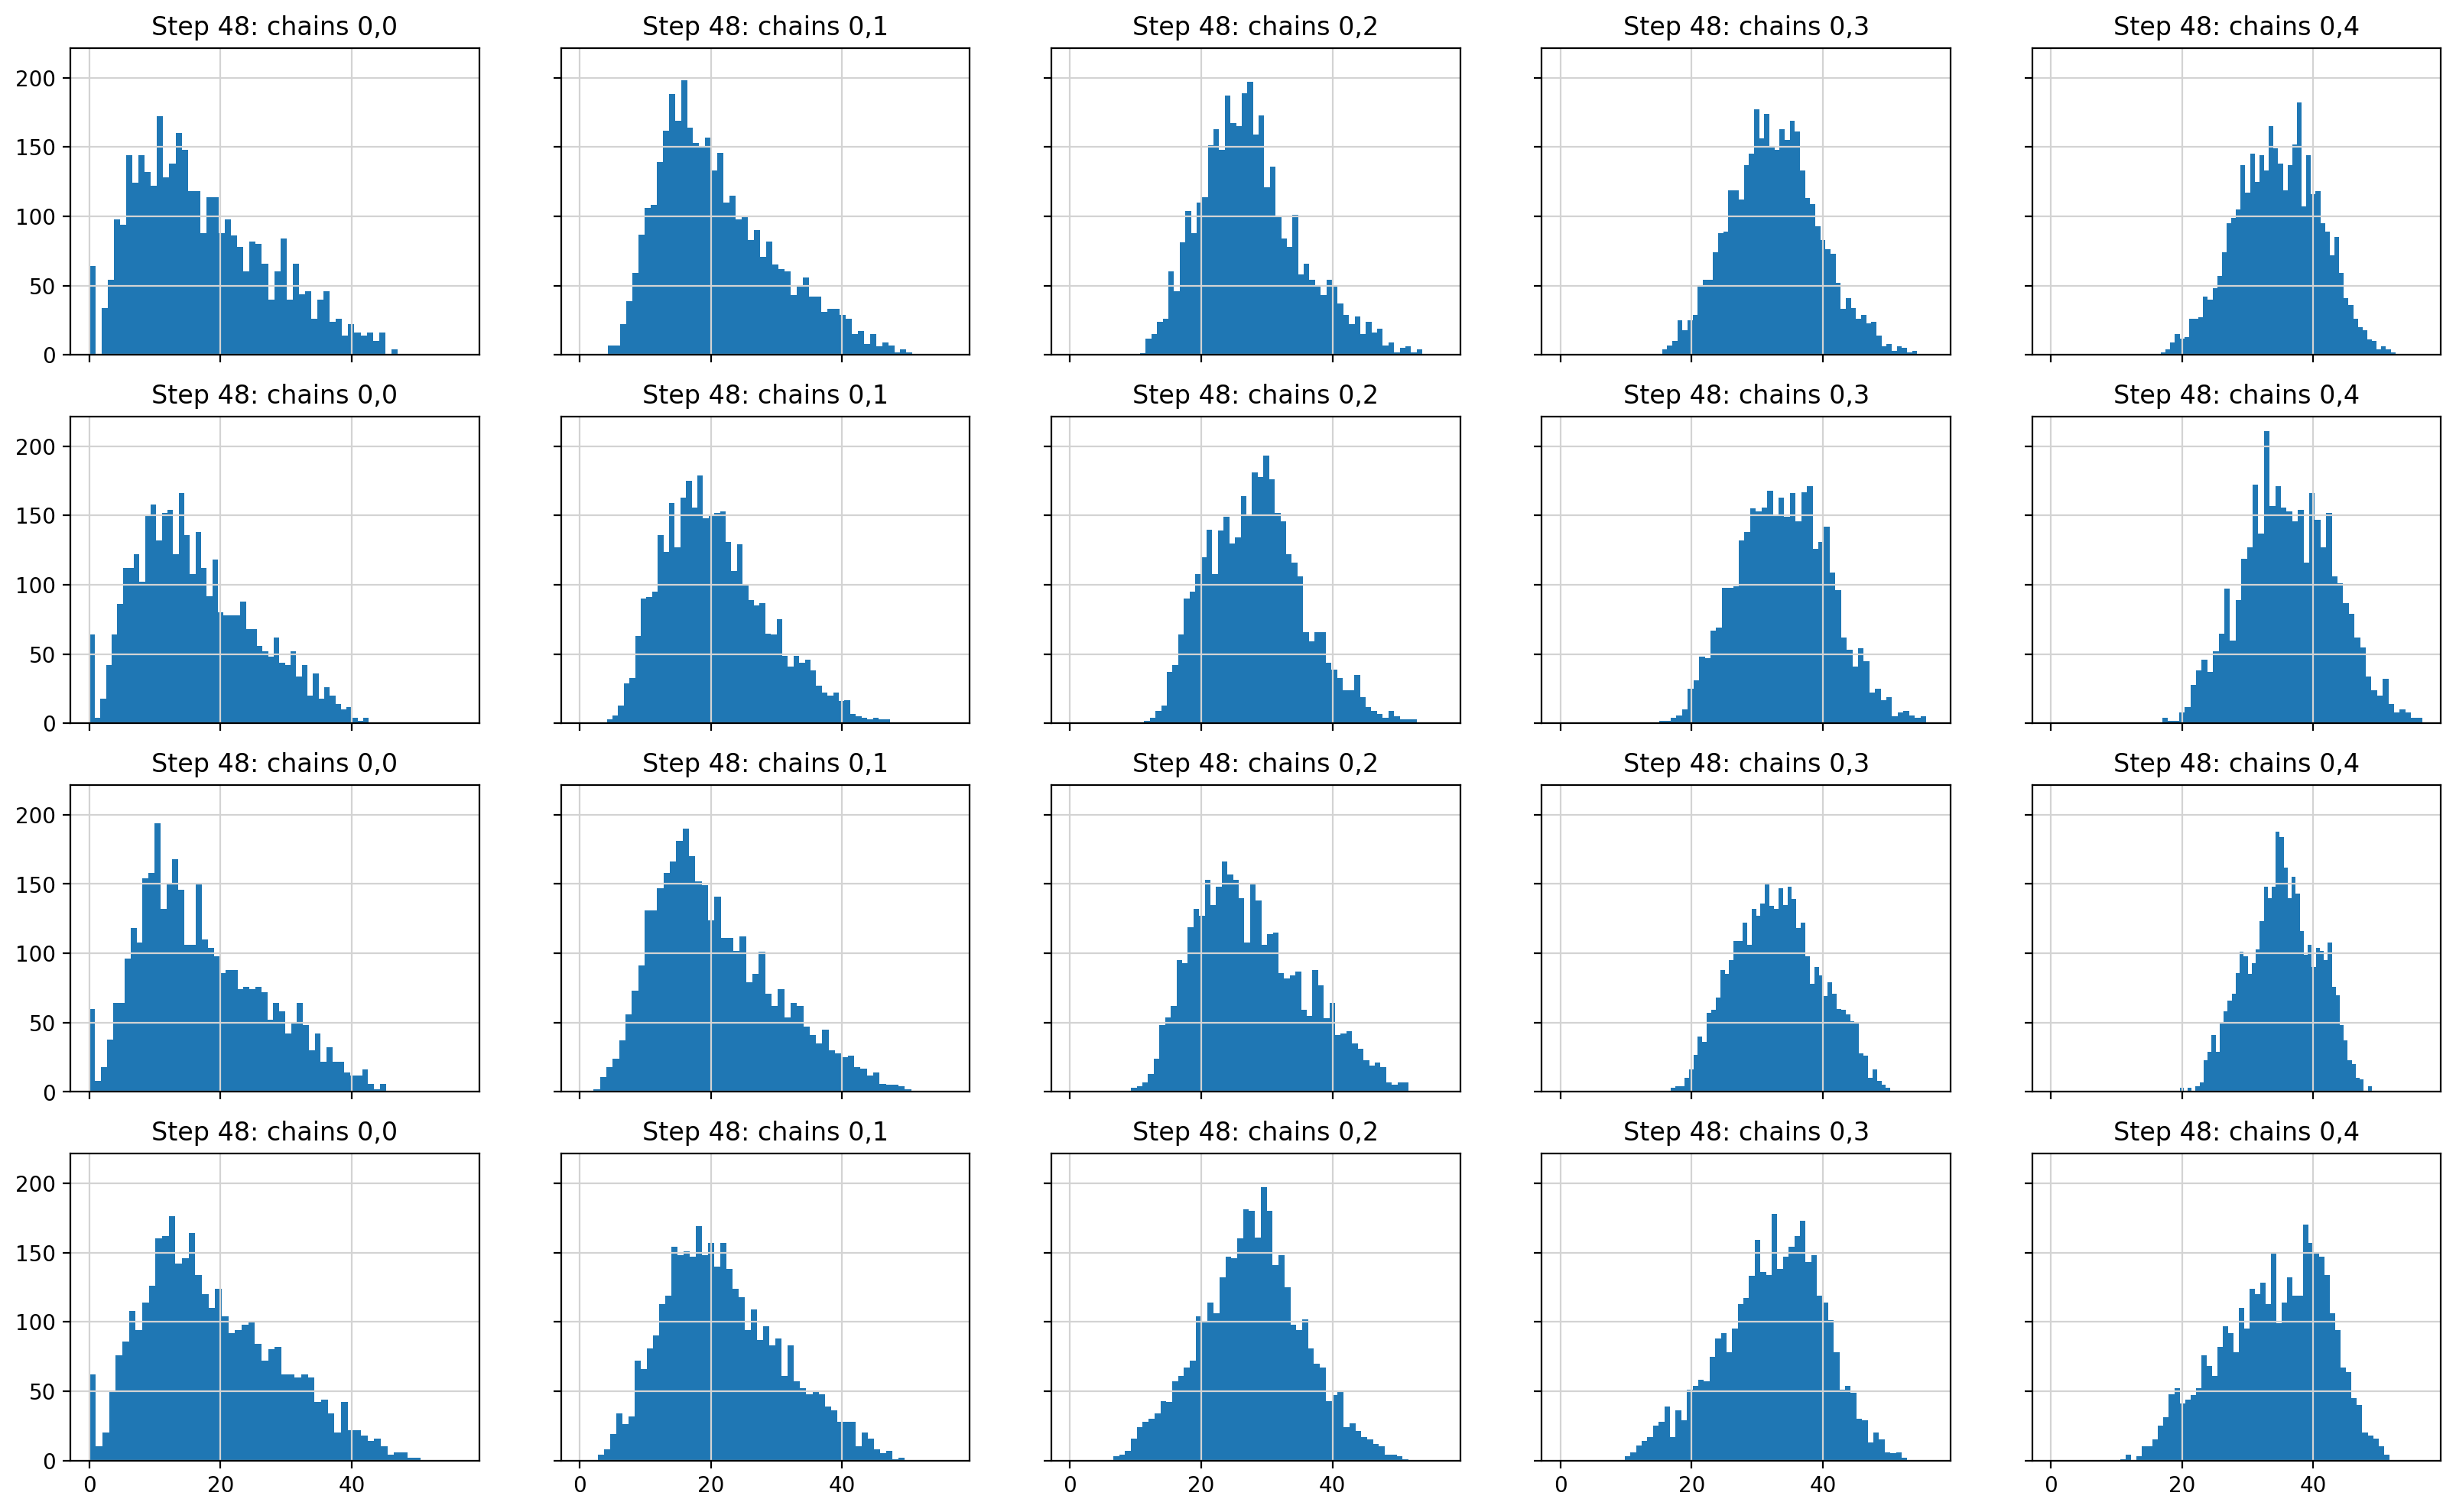

In [10]:
step_T = 48

rows, cols = 4, 5

fig, ax = plt.subplots(rows,cols,figsize=(4*cols, 3*rows), sharey=True, sharex=True)


for idx in range(rows*cols): 
    j = idx % cols
    i = idx // cols
    T = step_T

    distances = get_chain_distance(T, 0, j, num=i)
    
    axis = ax[i,j]
    axis.grid(':', c="lightgrey", zorder=0)
    axis.hist(distances, bins=50)
    axis.set_title(f"Step {T}: chains {0},{j}")